In [8]:
import ast
import pandas as pd
import sys
import matplotlib.pylab as plt
import operator
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder
import pyfpgrowth
import timeit

In [9]:
uid_songid_file_location = './Dataset/Result_by_userid_count_single_song.csv'
songid_mappings_file_location = './Dataset/kaggle_songs.txt'

In [10]:
uid_songid_file = open(uid_songid_file_location)
uid_songid_file_data = []
for line in uid_songid_file:
    to_be_appended = line.strip().replace('[','').replace(']','').replace('"','').replace("'",'').strip().replace(' ','').split(',')
    uid_songid_file_data.append(to_be_appended[1:])
uid_songid_file_data = uid_songid_file_data[1:]
uid_songid_file.close()

In [11]:
songid_mappings_file = open(songid_mappings_file_location)
songid_mappings = {}
for line in songid_mappings_file:
    temp_var = line.strip().split()
    songid_mappings[temp_var[0]] = int(temp_var[1])

songid_mappings_file.close()
#songid_mappings

In [12]:
#In transactional type data, convert hashed song_id to its corresponding numerical song_id 

for itemset in uid_songid_file_data:
    for item_num in range(len(itemset)):
        if(type(itemset[item_num]) == str):
            itemset[item_num] = itemset[item_num].strip()
            itemset[item_num] = songid_mappings[itemset[item_num]]   
    itemset.sort()

In [13]:
#Modify the data to reflect if a song is preferred with high, medium or low frequency by a user. 
#NOTE: Call this only once. Calling it again and again can append L/M/H again and again and we don't want that.

for user_num in range(len(uid_songid_file_data)):
    itemset = uid_songid_file_data[user_num]
    sid_dict = {}
    new_itemset = []
    for item in itemset:
        if(item in sid_dict):
            sid_dict[item] += 1
        else:
            sid_dict[item] = 1
    for sid,frequency in sid_dict.items():
        new_sid = str(sid)
        if(frequency<5):
            new_sid += 'L'
        if(frequency>=5 and frequency<10):
            new_sid += 'M'
        if(frequency>=10):
            new_sid +='H'
        new_itemset.append(new_sid)
        
    uid_songid_file_data[user_num] = new_itemset

uid_songid_file_data[3]

['115697L',
 '228083L',
 '83123L',
 '126580L',
 '41446L',
 '141927L',
 '289108L',
 '297161L',
 '85724L',
 '168365L',
 '375283L']

In [14]:
uid_songid_transaction_data = uid_songid_file_data
#len(uid_songid_transaction_data)

In [15]:
patterns = pyfpgrowth.find_frequent_patterns(uid_songid_transaction_data, 20)
len(patterns)

28001

In [16]:
sorted_patterns = sorted(patterns.items(), key=operator.itemgetter(1),reverse=True)
# for i in sorted_patterns:
#     print(i)
#sorted_x[1:1000]

In [17]:
rules = pyfpgrowth.generate_association_rules(patterns, 0.5)
len(rules)
#rules

204

In [18]:
#Run FP for various different Min Sup values

MAX_NUM = 8
MIN_CONF = 0.5
min_sup_array = [5*(2**i) for i in range(0,MAX_NUM)]
#min_sup_array = [10, 20, 40, 80, 160, 320, 640, 1280, 2560, 5120, 10240]
num_itemsets_array = []
time_taken_array = []
num_association_rules_array = []
for i in range(len(min_sup_array)):
    start = timeit.default_timer()
    patterns = pyfpgrowth.find_frequent_patterns(uid_songid_transaction_data, min_sup_array[i])
    num_itemsets_array.append(len(patterns))
    stop = timeit.default_timer()
    time_taken_array.append(stop-start)
    rules = pyfpgrowth.generate_association_rules(patterns, MIN_CONF)
    num_association_rules_array.append(len(rules))


In [19]:
num_itemsets_array

[293744, 80708, 28001, 10352, 3496, 1074, 313, 121]

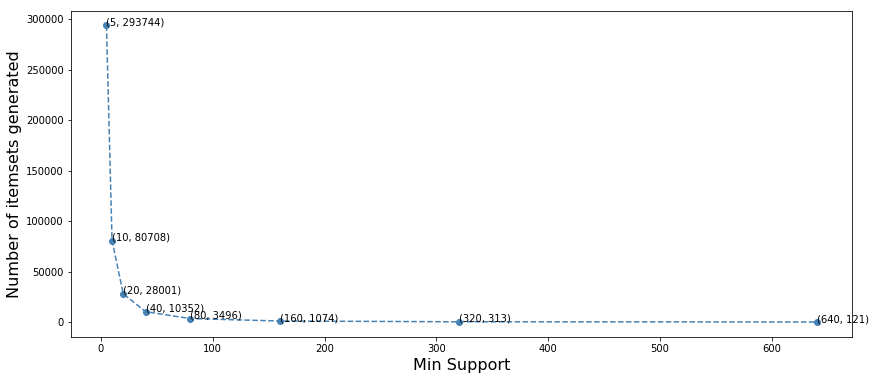

In [20]:
#Plot number of itemsets with respect to MIN_SUP 

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,6))
ax.plot(min_sup_array, num_itemsets_array, color="steelblue",linestyle='--', marker='o')
ax.set_xlabel("Min Support", fontsize=16)
ax.set_ylabel("Number of itemsets generated", fontsize=16)
for i in range(0,len(num_itemsets_array)):
    plt.text(min_sup_array[i], num_itemsets_array[i],'({}, {})'.format(min_sup_array[i], num_itemsets_array[i]))
plt.show()

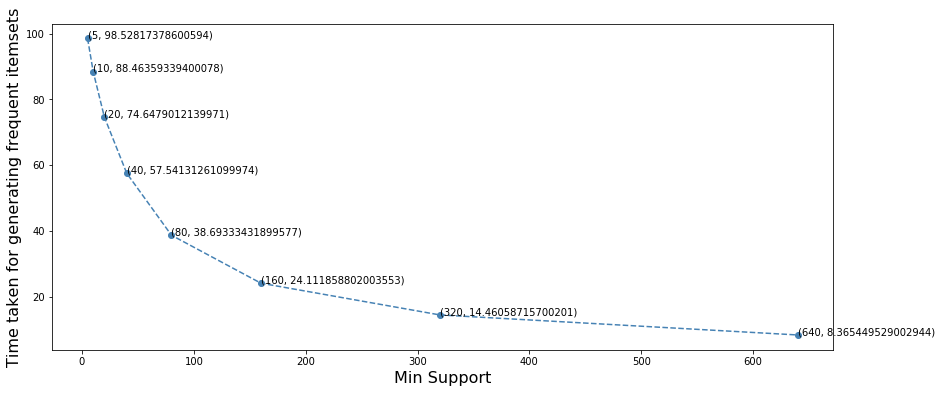

In [21]:
#Plot time taken to find frequent itemsets with respect to MIN_SUP

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,6))
ax.plot(min_sup_array, time_taken_array, color="steelblue",linestyle='--', marker='o')
ax.set_xlabel("Min Support", fontsize=16)
ax.set_ylabel("Time taken for generating frequent itemsets", fontsize=16)
for i in range(0,len(time_taken_array)):
    plt.text(min_sup_array[i], time_taken_array[i],'({}, {})'.format(min_sup_array[i], time_taken_array[i]))
plt.show()

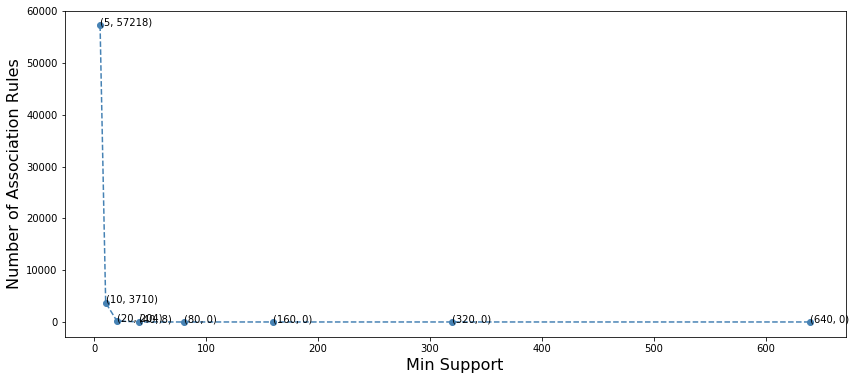

In [22]:
#Plot number of association rules with respect to MIN_SUP 

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,6))
ax.plot(min_sup_array, num_association_rules_array, color="steelblue",linestyle='--', marker='o')
ax.set_xlabel("Min Support", fontsize=16)
ax.set_ylabel("Number of Association Rules", fontsize=16)
for i in range(0,len(num_association_rules_array)):
    plt.text(min_sup_array[i], num_association_rules_array[i],'({}, {})'.format(min_sup_array[i], num_association_rules_array[i]))
plt.show()

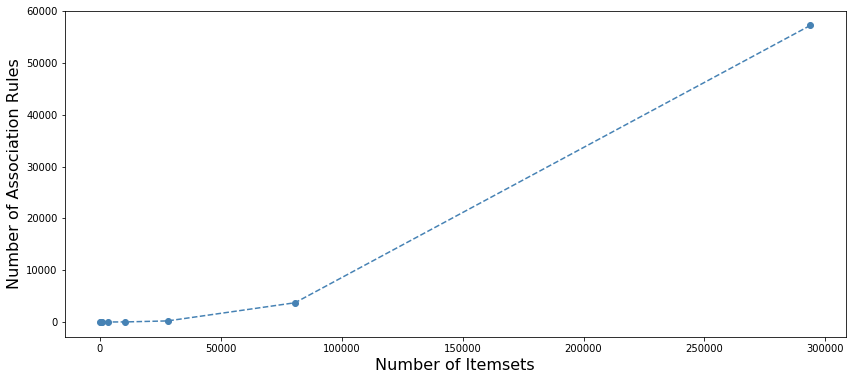

In [23]:
#Plot number of association rules with respect to number of itemsets

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,6))
ax.plot(num_itemsets_array, num_association_rules_array, color="steelblue",linestyle='--', marker='o')
ax.set_xlabel("Number of Itemsets", fontsize=16)
ax.set_ylabel("Number of Association Rules", fontsize=16)
# for i in range(0,len(num_association_rules_array)):
#     plt.text(num_itemsets_array[i], num_association_rules_array[i],'({}, {})'.format(num_itemsets_array[i], num_association_rules_array[i]))
plt.show()

In [24]:
#Run FP and generate association rules for various different values of MIN_CONF

MIN_CONF_ARRAY = [0.1*i for i in range(1,11)]
MIN_SUP = 20
#min_sup_array = [10*(2**i) for i in range(0,MAX_NUM)]
#min_sup_array = [10, 20, 40, 80, 160, 320, 640, 1280, 2560, 5120, 10240]
time_taken_array = []
num_association_rules_array = []
for i in range(len(MIN_CONF_ARRAY)):
    patterns = pyfpgrowth.find_frequent_patterns(uid_songid_transaction_data, MIN_SUP)
    start = timeit.default_timer()
    rules = pyfpgrowth.generate_association_rules(patterns, MIN_CONF_ARRAY[i])
    stop = timeit.default_timer()
    num_association_rules_array.append(len(rules))
    time_taken_array.append(stop-start)

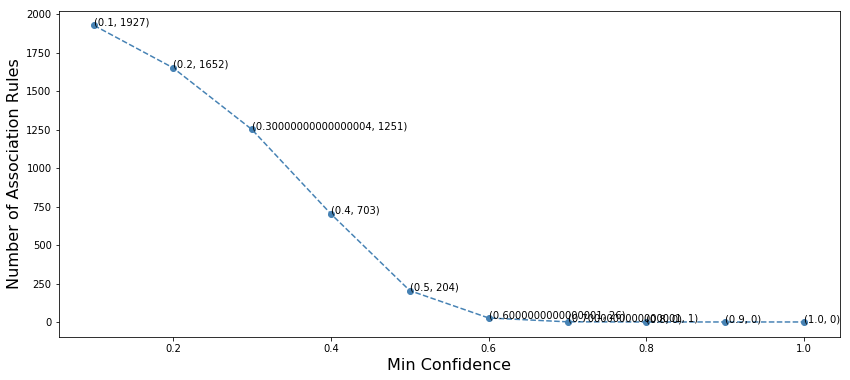

In [25]:
#Plot number of association rules with respect to Confidence Values 

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,6))
ax.plot(MIN_CONF_ARRAY, num_association_rules_array, color="steelblue",linestyle='--', marker='o')
ax.set_xlabel("Min Confidence", fontsize=16)
ax.set_ylabel("Number of Association Rules", fontsize=16)
for i in range(0,len(num_association_rules_array)):
    plt.text(MIN_CONF_ARRAY[i], num_association_rules_array[i],'({}, {})'.format(MIN_CONF_ARRAY[i], num_association_rules_array[i]))
plt.show()

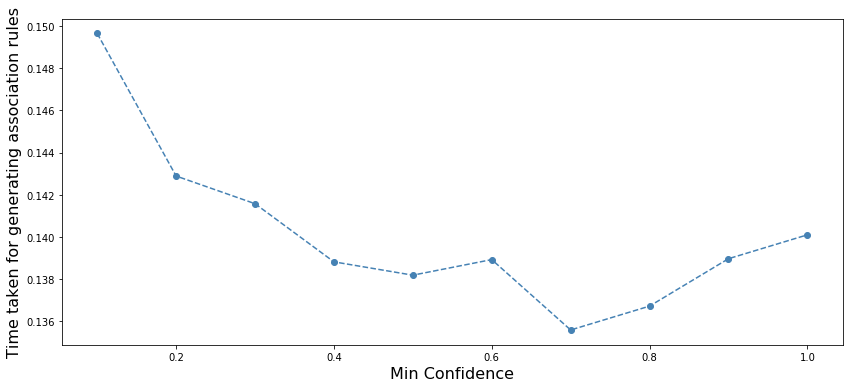

In [26]:
#Plot time taken to generate association rules with respect to MIN_CONF

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,6))
ax.plot(MIN_CONF_ARRAY, time_taken_array, color="steelblue",linestyle='--', marker='o')
ax.set_xlabel("Min Confidence", fontsize=16)
ax.set_ylabel("Time taken for generating association rules", fontsize=16)
# for i in range(0,len(time_taken_array)):
#     plt.text(MIN_CONF_ARRAY[i], time_taken_array[i],'({}, {})'.format(MIN_CONF_ARRAY[i], time_taken_array[i]))
plt.show()

In [27]:
#Run FP and generate association rules for various different values of MIN_CONF

MAX_NUM = 8
MIN_CONF_ARRAY = [0.1*i for i in range(1,11)]
min_sup_array = [10*(2**i) for i in range(0,MAX_NUM)]
#min_sup_array = [10, 20, 40, 80, 160, 320, 640, 1280, 2560, 5120, 10240]
OVERALL_time_taken_array = []
OVERALL_num_association_rules_array = []
for i in range(len(min_sup_array)):
    MIN_SUP = min_sup_array[i]
    time_taken_array = []
    print("Calculating for MIN_SUP = " + str(MIN_SUP))
    num_association_rules_array = []
    for i in range(len(MIN_CONF_ARRAY)):
        patterns = pyfpgrowth.find_frequent_patterns(uid_songid_transaction_data, MIN_SUP)
        start = timeit.default_timer()
        rules = pyfpgrowth.generate_association_rules(patterns, MIN_CONF_ARRAY[i])
        stop = timeit.default_timer()
        num_association_rules_array.append(len(rules))
        time_taken_array.append(stop-start)
        
    OVERALL_time_taken_array.append(time_taken_array)
    OVERALL_num_association_rules_array.append(num_association_rules_array)

Calculating for MIN_SUP = 10
Calculating for MIN_SUP = 20
Calculating for MIN_SUP = 40
Calculating for MIN_SUP = 160
Calculating for MIN_SUP = 320
Calculating for MIN_SUP = 640
Calculating for MIN_SUP = 1280


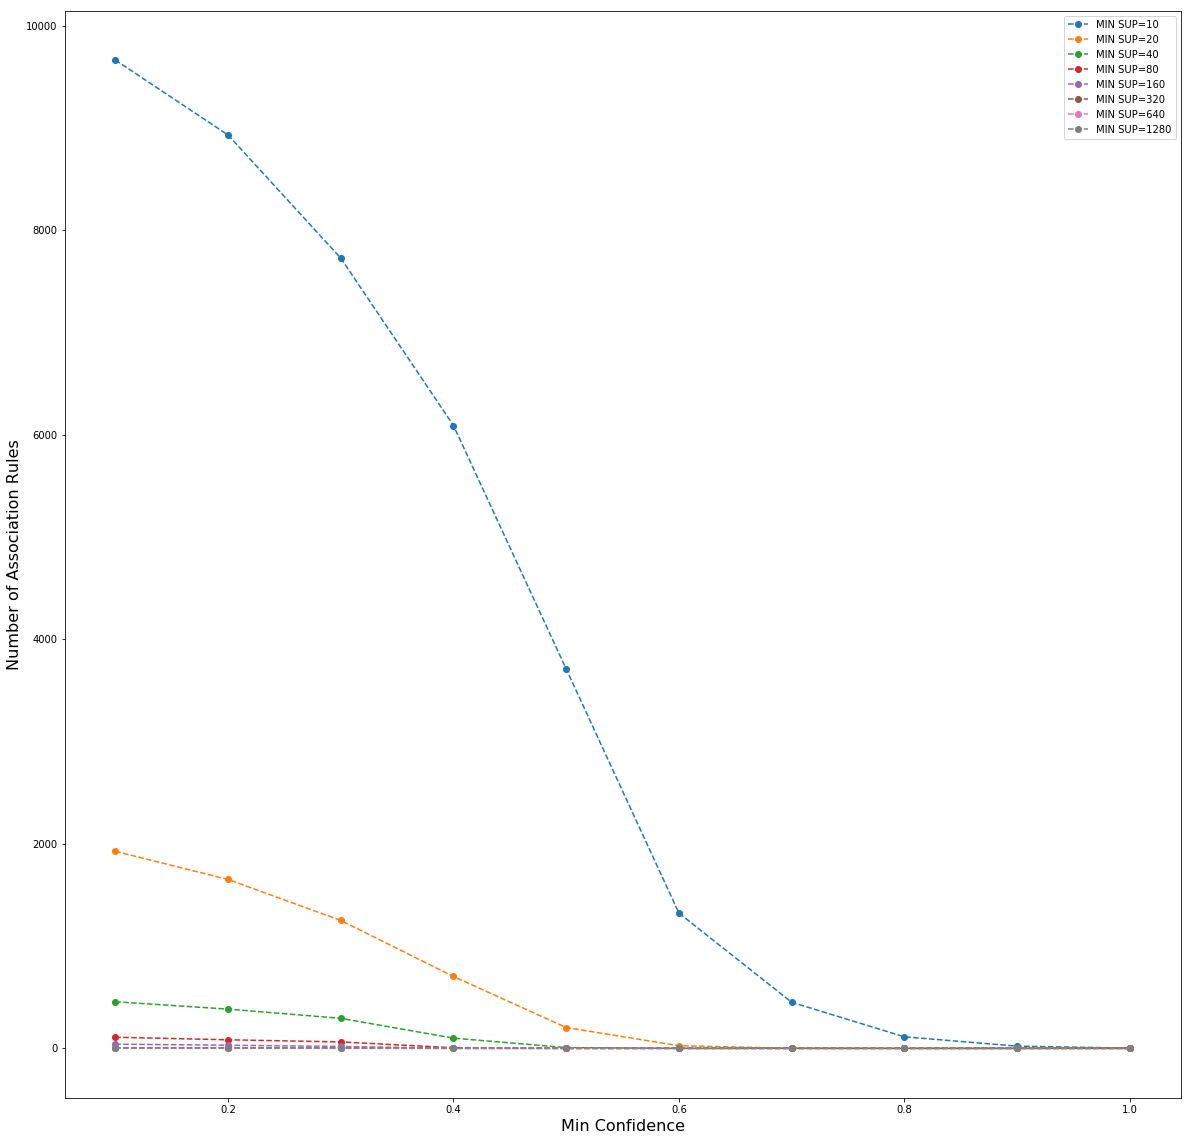

In [28]:
#Plot number of association rules with respect to Confidence Values for different support values

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,20))

for i in range(0,len(min_sup_array)):
    ax.plot(MIN_CONF_ARRAY, OVERALL_num_association_rules_array[i], linestyle='--', marker='o',label="MIN SUP=" + str(min_sup_array[i]))
    
ax.set_xlabel("Min Confidence", fontsize=16)
ax.set_ylabel("Number of Association Rules", fontsize=16)
ax.legend()
# for i in range(0,len(num_association_rules_array)):
#     plt.text(MIN_CONF_ARRAY[i], num_association_rules_array[i],'({}, {})'.format(MIN_CONF_ARRAY[i], num_association_rules_array[i]))
plt.show()

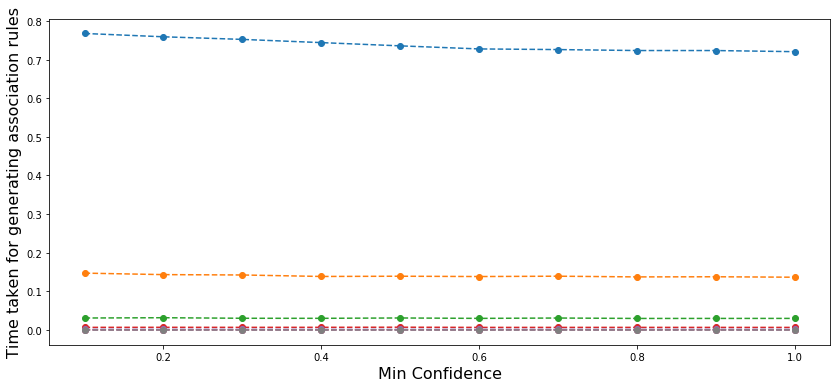

In [29]:
#Plot time taken to generate association rules with respect to Confidence Values for different support values

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,6))

for i in range(len(min_sup_array)):
    ax.plot(MIN_CONF_ARRAY, OVERALL_time_taken_array[i],linestyle='--', marker='o')
    
ax.set_xlabel("Min Confidence", fontsize=16)
ax.set_ylabel("Time taken for generating association rules", fontsize=16)
# for i in range(0,len(num_association_rules_array)):
#     plt.text(MIN_CONF_ARRAY[i], num_association_rules_array[i],'({}, {})'.format(MIN_CONF_ARRAY[i], num_association_rules_array[i]))
plt.show()